In [2]:
from qiskit.tools.jupyter import *
from qiskit import IBMQ
import numpy as np
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import pulse
from qiskit.circuit import Parameter
from qubit_characterization_functions import *

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit = 0
mem_slot = 0
qubit_frequency_ini = backend_defaults.qubit_freq_est[qubit]

ibmqfactory.load_account:WARNING:2022-04-17 20:16:20,536: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

scale_factor = 1e-14

drive_sigma_sec = 0.075 * us
drive_duration_sec = drive_sigma_sec * 8

# 1. Qubit Spectroscopy

In [3]:
frequency_list = np.arange(qubit_frequency_ini - 20*MHz, qubit_frequency_ini + 20*MHz, 1*MHz)

In [4]:
qubit_spec_schedule = qubit_spectroscopy(backend=backend, drive_duration_sec=drive_duration_sec, drive_sigma_sec=drive_sigma_sec, drive_amp=0.05, qubit=qubit, mem_slot=mem_slot, frequency_list=frequency_list)

In [5]:
num_shots_per_point = 1024

qubit_spectro_job = backend.run(qubit_spec_schedule,
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_point)

job_monitor(qubit_spectro_job)

Job Status: job has successfully run


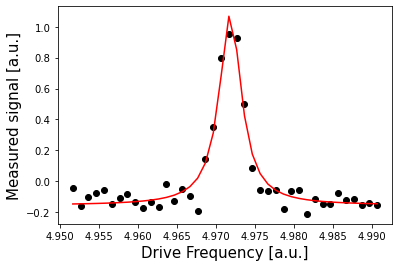

In [6]:
qubit_frequency_meas = qubit_spectroscopy_plot(qubit_spectro_job = qubit_spectro_job, qubit = qubit, scale_factor = scale_factor, frequency_list = frequency_list)

# 2. Rabi Oscillation

In [7]:
amplitude_min = 0
amplitude_max = 0.8
amplitude_list = np.linspace(amplitude_min, amplitude_max, 30)

In [8]:
rabi_schedules = rabi_schedule(backend = backend, drive_duration_sec = drive_duration_sec, drive_sigma_sec = drive_sigma_sec, qubit = qubit, qubit_frequency = qubit_frequency_meas, mem_slot = mem_slot, amplitude_list = amplitude_list)

In [9]:
num_shots_per_point = 1024
rabi_job = backend.run(rabi_schedules,
                  meas_level=1,
                  meas_return='avg',
                  shots=num_shots_per_point)
job_monitor(rabi_job)

Job Status: job has successfully run


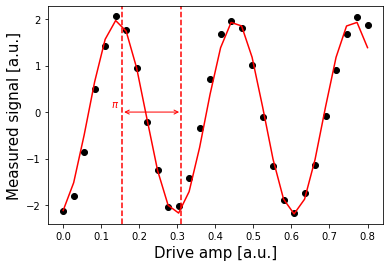

In [10]:
Xgate_amplitude = rabi_plot(drive_amps = amplitude_list, rabi_job = rabi_job, qubit = qubit, scale_factor = scale_factor)

# 3. T1 Measurement

In [11]:
pi_amp = abs(Xgate_amplitude)
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

In [12]:
t1_schedules = t1_schedule(backend = backend, drive_duration_sec = drive_duration_sec,  drive_sigma_sec = drive_sigma_sec, qubit = qubit, pi_amp = pi_amp, qubit_frequency_ini = qubit_frequency_ini, mem_slot = mem_slot, delay_times_sec = delay_times_sec)

In [13]:
num_shots = 256
t1_job = backend.run(rabi_schedules, meas_level = 1, meas_return = 'avg', shots = num_shots_per_point)
job_monitor(t1_job)

Job Status: job has successfully run


In [1]:
result = t1_job.result()

NameError: name 't1_job' is not defined

In [14]:
t1_measurements = t1_measurement(t1_job = t1_job, qubit = qubit, scale_factor = scale_factor, num_shots = num_shots, delay_times_sec= delay_times_sec, us = us)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# 4. T2 Measurement

In [ ]:
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec_t2 = np.arange(2 * us, tau_max_sec, tau_step_sec)
drive_amp = pi_amp / 2

In [ ]:
t2_schedules = t2_schedule(backend = backend, drive_duration_sec = drive_duration_sec, drive_sigma_sec = drive_sigma_sec, qubit = qubit, drive_amp = drive_amp, qubit_frequency_ini = qubit_frequency_ini, pi_pulse = pi_amp, mem_slot = mem_slot, delay_times_sec_t2 = delay_times_sec_t2)

In [ ]:
num_shots_per_point = 512

t2_echo_job = backend.run(t2_schedules, meas_level = 1, meas_return = 'avg', shots = num_shots_per_point)

job_monitor(t2_echo_job)

In [ ]:
t2_measurements = t2_measurement(t2_echo_job = t2_echo_job, delay_times_sec_t2 = delay_times_sec_t2, qubit = qubit, scale_factor = scale_factor, num_shots_per_point = num_shots_per_point, us = us)